<a href="https://colab.research.google.com/github/sipocz/Zindi_plastic/blob/main/Zindi_Plastic_Cover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
import PIL
import pandas
from google.colab import drive


In [ ]:
_DEBUG_=False
_PROJECT_BASE_='/content/drive/MyDrive/zindi_plastic/'
_IMAGES_='images'
_ORIG_='orig'

In [ ]:
ee.Authenticate()
ee.Initialize(project='zindiplasticproject')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def add_time(image):
  return image.addBands(image.getNumber('system:time_start'))

In [ ]:
def conditional(image):
  return ee.Algorithms.If(
      ee.Number(image.get('SUN_ELEVATION')).gt(40), image, ee.Image(0)
  )


In [ ]:
def gamma_correct(gamma, path):
    im = PIL.Image.open(path)
    gamma1 = gamma
    row = im.size[0]
    col = im.size[1]
    result_img1 = PIL.Image.new(mode="RGB", size=(row, col), color=0)
    for x in range(row):
        for y in range(col):
            r = pow(im.getpixel((x, y))[0] / 255, (1 / gamma1)) * 255
            g = pow(im.getpixel((x, y))[1] / 255, (1 / gamma1)) * 255
            b = pow(im.getpixel((x, y))[2] / 255, (1 / gamma1)) * 255
            # add
            color = (int(r), int(g), int(b))
            result_img1.putpixel((x, y), color)
    #show
    return result_img1

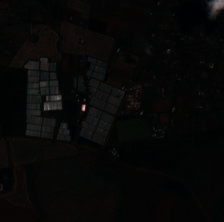

In [ ]:
def image_download(index=int,longitude=float,latitude=float,place=str,sat=None,band=None):
    from math import gamma
    import geemap
    import ee

    # Google Earth Engine inicializálása
    ee.Initialize()

    '''
    #Plastic
    latitude = 0.046038658
    longitude = 37.05905382

    #Plastic
    latitude = 0.122844615
    longitude = 37.39250845

    #NONPlastic
    latitude = 0.037953821
    longitude = 37.05797584

    #Plastic
    latitude = 0.122215794
    longitude = 37.39250845
    '''



    if sat==None:
        sat='COPERNICUS/S2_HARMONIZED'
    if band==None:
        band=['B4','B3','B2']

    # 1000 méteres körzet létrehozása Budapest középpontjában
    point = ee.Geometry.Point([longitude, latitude])
    buffer = point.buffer(10).bounds()  # 1000 méteres buffer

    # Sentinel-2 műholdkép lekérése nappali időszakban
    collection = ee.ImageCollection(sat) \
        .filterBounds(buffer) \
        .filterDate('2023-04-01', '2024-09-01') \
        .sort('CLOUDY_PIXEL_PERCENTAGE')  # Legkevésbé felhős kép kiválasztása
    first_image = collection.first()  # Az első legkevésbé felhős kép

    # Ellenőrizd, hogy az első kép érvényes
    if first_image is None:
        raise ValueError("Nem találtunk érvényes képet a megadott időszakban.")

    # Kép RGB sávok kiválasztása
    image = first_image.select(band)  # Red, Green, Blue
    import matplotlib.pyplot as plt

    aoi=ee.Geometry.Rectangle(longitude-0.003,latitude-0.003,longitude+0.003,latitude+0.003 )


    rgb_img = geemap.ee_to_numpy(image,region=aoi)
    if _DEBUG_==True:
        print(rgb_img.shape)

    rgb_img_test = (255 * ((rgb_img[:, :, 0:3] ) / rgb_img[:,:,:].max())).astype("uint8")
    img=PIL.Image.fromarray(rgb_img_test)

    img=img.resize((192,192))
    return img


In [ ]:
pil_image=image_download(20,37.05635887,0.053674338,"Kenya",sat="COPERNICUS/S2_HARMONIZED",band=['B4','B3','B2'])

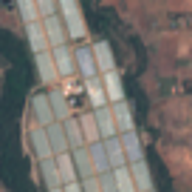

In [ ]:
pil_image

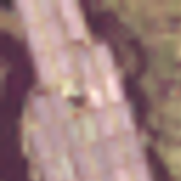

In [ ]:
pil_image.crop((0,0,181,181))


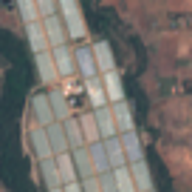

In [ ]:
image_download(20,37.05635887,0.053674338,"Kenya")

In [ ]:

df_kenya=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Kenya_training.csv")
_image_id_="_kenya"

In [ ]:
df_kenya.head()

,ID,lon,lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,37.059054,0.046039,2731.0,3035.0,5418.0,5306.5,2958.0,4610.5,5099.5,2994.0,4108.5,3187.5,-6.861458,-12.162713,1
1,2,37.059503,0.047296,2921.0,3329.0,5834.0,6472.0,4144.5,5782.0,6302.0,3344.0,5269.0,4471.5,-8.082717,-14.619608,1
2,3,37.057527,0.047656,3828.0,4163.0,6420.0,7890.5,5408.5,6695.5,7302.0,4380.0,6905.0,6905.5,-7.767043,-14.880353,1
3,4,37.057976,0.047925,2556.0,2839.0,4822.0,5276.5,3201.0,4643.0,5069.5,2787.0,3832.0,2867.5,-7.773118,-15.587653,1
4,5,37.056359,0.048554,3790.0,4009.0,6476.0,6199.5,4285.0,5711.0,6079.5,3939.0,4892.5,3702.5,-6.104467,-15.431915,1


In [ ]:
def image_generation(df,image_id):
    for i,row in df.iterrows():
        image=image_download(row.ID,row.lon,row.lat,image_id,sat=_sat_,band=_band_)
        image.save(_PROJECT_BASE_+_IMAGES_+"/"+str(int(row.ID))+'_'+str(int(row.TARGET))+"_"+image_id+".jpg")
        print(i,end=".")

In [ ]:
_sat_=None
_band_=None
_image_id_="kenya"

In [ ]:
image_generation(df_kenya,_image_id_)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

<generator object DataFrame.iterrows at 0x792fc6412730>

In [ ]:
#!rm /content/drive/MyDrive/zindi_plastic/images/*landsat.jpg

In [ ]:
df_spain=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/Spain_training.csv")
_image_id_="spain"

In [ ]:
image_generation(df_spain,_image_id_)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

In [ ]:
df_vnm=pandas.read_csv(_PROJECT_BASE_+_ORIG_+"/VNM_training.csv")
_image_id_="vnm"

In [ ]:
image_generation(df_vnm,_image_id_)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

In [ ]:
df_vnm.head()

,ID,lon,lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1


In [ ]:
dsfsdf

In [ ]:
_sat_="LANDSAT/LC08/C02/T1_L2"
_band_=['SR_B7','SR_B3','SR_B2']
_image_id_="_kenya_landsat"

In [ ]:
image_generation(df_kenya,_image_id_)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

In [ ]:
# END of Image generation

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
def format_image(image_dir):
    image = tf.read_file(image_dir)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_image_with_pad(image, 256, 256, align_corners=True)
    return image

In [95]:

imagedir="./drive/MyDrive/Zindi_plastic/images"
img_width,img_height=192,192
batch_size=5


In [96]:
!cd ./drive/MyDrive/zindi_plastic/images

In [97]:
!cd ./drive/MyDrive/zindi_plastic/images
!pwd
!mv ./drive/MyDrive/zindi_plastic/images/*_1__*.jpg ./drive/MyDrive/zindi_plastic/images/plastic
!mv ./drive/MyDrive/zindi_plastic/images/*_2__*.jpg ./drive/MyDrive/zindi_plastic/images/non_plastic

/content
mv: cannot stat './drive/MyDrive/zindi_plastic/images/*_1__*.jpg': No such file or directory
mv: cannot stat './drive/MyDrive/zindi_plastic/images/*_2__*.jpg': No such file or directory


In [184]:

import pandas as pd

In [185]:
train_path='./drive/MyDrive/zindi_plastic/images'


test_path='./drive/MyDrive/zindi_plastic/images'
valid_path='./drive/MyDrive/zindi_plastic/images'

In [186]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [187]:
# extract images to training set by applying data preprocessing and data augmentation
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['plastic', 'non_plastic'], batch_size=1, subset='training')


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['plastic', 'non_plastic'], batch_size=1, subset='validation')



Found 2261 images belonging to 2 classes.
Found 564 images belonging to 2 classes.


In [188]:
import matplotlib.pyplot as plt
def plot_imgs(item_dir, top=100):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(2, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')



['plastic', 'non_plastic']


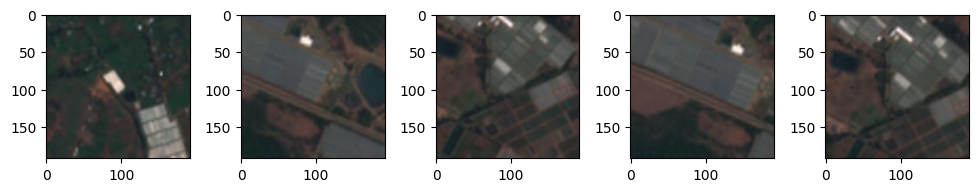

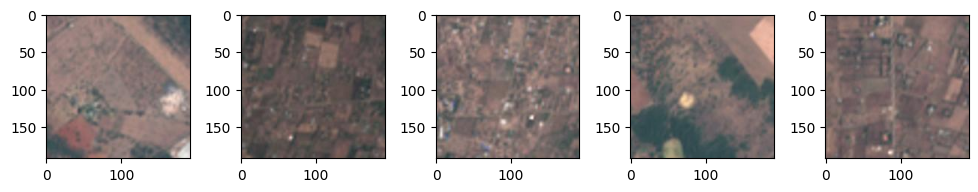

In [189]:
import os
print(os.listdir(train_path))

data_path = train_path

plot_imgs(data_path+'/plastic')

plot_imgs(data_path+'/non_plastic')


In [190]:
batch_size = 1


x_pxm=224
y_pxm=224
divider=1
bpc=3


# Data Generator
train=ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.0,zoom_range = 0.0,
                         width_shift_range = 0.0,
                         height_shift_range = 0.0,)

test=ImageDataGenerator(rescale=1./255,validation_split=0.1)


x_px=int(x_pxm/divider)
y_px=int(y_pxm/divider)

print(f"X: {x_px}, Y: {y_px}")
train_generator=train.flow_from_directory(data_path,target_size=(x_px,y_px),batch_size=batch_size,class_mode='binary',subset='training',color_mode="rgb")
test_generator=test.flow_from_directory(data_path,target_size=(x_px,y_px),batch_size=batch_size,class_mode='binary',subset='validation',color_mode="rgb")



train_generator.class_mode

X: 224, Y: 224
Found 2543 images belonging to 2 classes.
Found 282 images belonging to 2 classes.


'binary'

In [191]:

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'non_plastic', 1: 'plastic'}


In [192]:
num_classes = 2





from tensorflow.keras.layers import Input,Dense,Embedding,LSTM,TimeDistributed, Flatten, Bidirectional, Conv2D,Conv3D, Dropout,Convolution2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Rescaling,RandomFlip,RandomRotation, Reshape,BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta,Adam,SGD,Adamax
from tensorflow.keras.losses import sparse_categorical_crossentropy,categorical_crossentropy, MeanSquaredError
from tensorflow.keras import backend as K
from keras.regularizers import l1
from keras.initializers import RandomNormal,Zeros,GlorotUniform
K.clear_session()



In [193]:
bpc

3

In [194]:

inputs= Input(shape=(224,224,3))


e = Conv2D(32, (3, 3), activation='relu',padding='same')(inputs)
e = Conv2D(32, (3, 3), activation='relu',padding='same')(e)
e = MaxPooling2D((2, 2),strides=(2, 2))(e)

e = Conv2D(64, (3, 3), activation='relu',padding='same')(e)
e = Conv2D(64, (3, 3), activation='relu',padding='same')(e)
e = MaxPooling2D((2, 2),strides=(2, 2))(e)

e = Conv2D(64, (3, 3), activation='relu',padding='same')(e)
e = Conv2D(64, (3, 3), activation='relu',padding='same')(e)
e = Conv2D(64, (3, 3), activation='relu',padding='same')(e)
e = MaxPooling2D((2, 2), strides=(2, 2))(e)

e = Conv2D(128, (3, 3), activation='relu',padding='same')(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same')(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same')(e)


e = MaxPooling2D((2, 2), strides=(2,2))(e)

e = Conv2D(128, (3, 3), activation='relu',padding='same')(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same')(e)
e = Conv2D(128, (3, 3), activation='relu',padding='same')(e)


e = MaxPooling2D((2, 2), strides=(2,2))(e)


l = Flatten()(e)
l = Dense(2000, activation='sigmoid')(l)

l = Dense(500, activation='sigmoid')(l)
l = Dense(20, activation='sigmoid')(l)



decoded = Dense(1, activation='sigmoid')(l)


autoencoder = Model(inputs, decoded)




In [199]:

from keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='Model_-{val_loss:.4f}.keras',


    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [195]:
model_path="plastic_cnn.h5"

#checkpoint1 = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')




paths=data_path
XSize=224
YSize=224


keras_ds = tf.keras.preprocessing.image_dataset_from_directory(paths, batch_size=1, image_size=(XSize, YSize),label_mode=None)







num_epochs = 5
step_size_train=train_generator.n//train_generator.batch_size
step_size_test =test_generator.n//test_generator.batch_size


from keras.models import load_model
#model=load_model(modelfname)


def scheduler(epoch, lr):
  return 0.01




LR_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


#callbacks_list = [checkpoint1,LR_callback]









cce = tf.keras.losses.SparseCategoricalCrossentropy()
bce=tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.SparseCategoricalAccuracy()

#optimizer=Adam()
#autoencoder.compile(loss="binary crossentropy", optimizer=optimizer, metrics=[cce,acc])
autoencoder.summary()

Found 2825 files.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2000)                │      12,546,000 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,544,669 (55.48 MB)

 Trainable params: 14,544,669 (55.48 MB)

 Non-trainable params: 0 (0.00 B)

In [196]:
'''
from keras.callbacks import ModelCheckpoint
from datetime  import datetime

times=datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'{datetime.now().strftime("%Y%m%d_%H%M%S")}')
best_model = ModelCheckpoint(filepath='Model_-{val_loss:.4f}.keras', monitor='val_loss', mode='min',verbose=1, save_best_only=True, save_freq="epoch")
'''



20240820_171412


In [197]:

# Train Model
from IPython.display import clear_output

for i in range(1):
    ratex={0:0.00001,1:0.000001,2:0.000005,3:0.000001,4:0.000005}
    epocsd={0:50,1:4,2:10,3:10,4:10}
    batchsd={0:16,1:1,2:1,3:1,4:1}
    clear_output(wait=True)
    print("-"*15)
    print(f"num: {i:4}, Learning Rate: {ratex[i]:9} epocs: {epocsd[i]:6}")
    print("-"*15)
    optimizer=Adam(ratex[i])


    autoencoder.summary()
    autoencoder.compile(loss=bce, optimizer=optimizer, metrics=["binary_accuracy",acc])
    history = autoencoder.fit(train_generator, epochs=epocsd[i],
                              validation_data=test_generator,
                              batch_size=batchsd[i],
                              callbacks=[model_checkpoint_callback])


---------------
num:    0, Learning Rate:     1e-05 epocs:     50
---------------


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2000)                │      12,546,000 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,544,669 (55.48 MB)

 Trainable params: 14,544,669 (55.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2543/2543 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - binary_accuracy: 0.5063 - loss: 0.7000 - sparse_categorical_accuracy: 0.5189 - val_binary_accuracy: 0.5248 - val_loss: 0.6901 - val_sparse_categorical_accuracy: 0.5248
Epoch 2/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - binary_accuracy: 0.5517 - loss: 0.6827 - sparse_categorical_accuracy: 0.5291 - val_binary_accuracy: 0.6773 - val_loss: 0.6238 - val_sparse_categorical_accuracy: 0.5248
Epoch 3/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - binary_accuracy: 0.6975 - loss: 0.5828 - sparse_categorical_accuracy: 0.5337 - val_binary_accuracy: 0.7411 - val_loss: 0.5417 - val_sparse_categorical_accuracy: 0.5248
Epoch 4/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - binary_accuracy: 0.8063 - loss: 0.4402 - sparse_categorical_accuracy: 0.5232 - val_binary_accuracy: 0.6986 - val_loss: 0.5633 - val_sparse_categorical_accuracy: 0.5248
Epoch 5/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - binary_accuracy: 0.8733 - loss: 0.3290 - sparse_c

In [200]:
 history = autoencoder.fit(train_generator, epochs=epocsd[i],
                              validation_data=test_generator,
                              batch_size=batchsd[i],
                              callbacks=[model_checkpoint_callback])

Epoch 1/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - binary_accuracy: 0.9673 - loss: 0.0999 - sparse_categorical_accuracy: 0.5258 - val_binary_accuracy: 0.9220 - val_loss: 0.2110 - val_sparse_categorical_accuracy: 0.5248
Epoch 2/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - binary_accuracy: 0.9641 - loss: 0.1071 - sparse_categorical_accuracy: 0.5185 - val_binary_accuracy: 0.9291 - val_loss: 0.1852 - val_sparse_categorical_accuracy: 0.5248
Epoch 3/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - binary_accuracy: 0.9599 - loss: 0.1137 - sparse_categorical_accuracy: 0.5413 - val_binary_accuracy: 0.9255 - val_loss: 0.1762 - val_sparse_categorical_accuracy: 0.5248
Epoch 4/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - binary_accuracy: 0.9593 - loss: 0.1251 - sparse_categorical_accuracy: 0.5352 - val_binary_accuracy: 0.9184 - val_loss: 0.2062 - val_sparse_categorical_accuracy: 0.5248
Epoch 5/50
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - binary_accuracy: 0.9722 - loss: 0.0928

In [202]:
!cp *.keras ./drive/MyDrive/zindi_plastic/models/

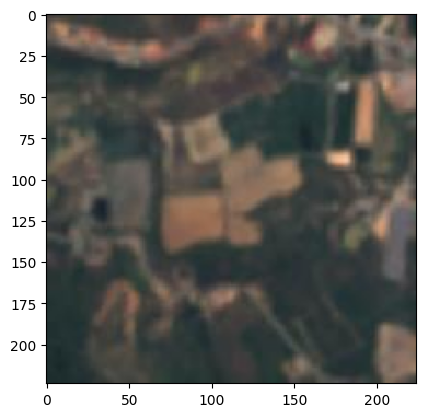

In [198]:
img1=train_generator[23][0][0]
imgplot = plt.imshow(img1)